In [66]:
#Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.ndimage import gaussian_filter1d

In [67]:
# Memuat data
df = pd.read_csv('DailyDelhiClimateTrain.csv')

# Mengubah kolom tanggal menjadi tipe datetime
df['date'] = pd.to_datetime(df['date'])

# Mengatur tanggal sebagai indeks untuk memudahkan resampling
df.set_index('date', inplace=True)

# Menampilkan beberapa baris pertama untuk memahami struktur data
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [68]:
# Mengecek Data yang Hilang
(df.isna().sum())


meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

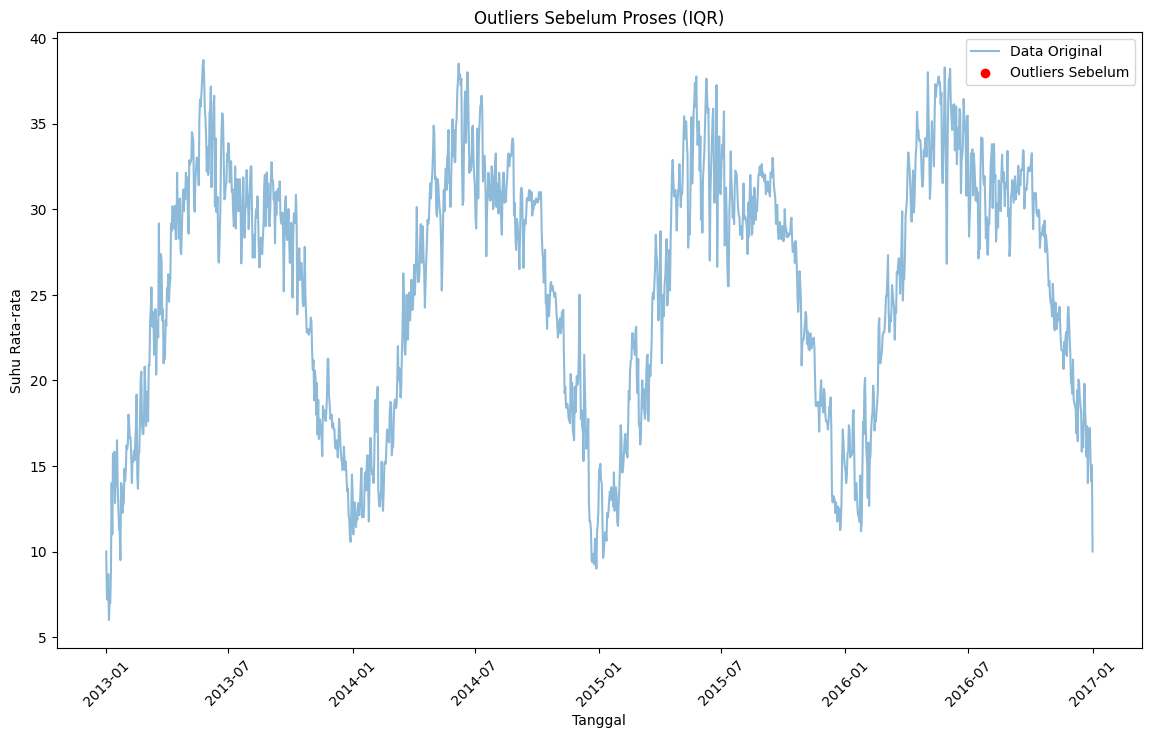

Outliers Sebelum Dihapus:
 Empty DataFrame
Columns: [meantemp, humidity, wind_speed, meanpressure]
Index: []


In [69]:
# --------------- Melihat Outliers Sebelum Proses IQR ---------------

# Menghitung batas outlier menggunakan IQR
Q1 = df['meantemp'].quantile(0.25)
Q3 = df['meantemp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifikasi outliers sebelum dihapus
outliers_before = df[(df['meantemp'] < lower_bound) | (df['meantemp'] > upper_bound)]

# Plot Data Original dan Outliers sebelum dihapus
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['meantemp'], label='Data Original', alpha=0.5)
plt.scatter(outliers_before.index, outliers_before['meantemp'], color='red', label='Outliers Sebelum', zorder=5)
plt.title('Outliers Sebelum Proses (IQR)')
plt.xlabel('Tanggal')
plt.ylabel('Suhu Rata-rata')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print outliers sebelum dihapus
print("Outliers Sebelum Dihapus:\n", outliers_before)

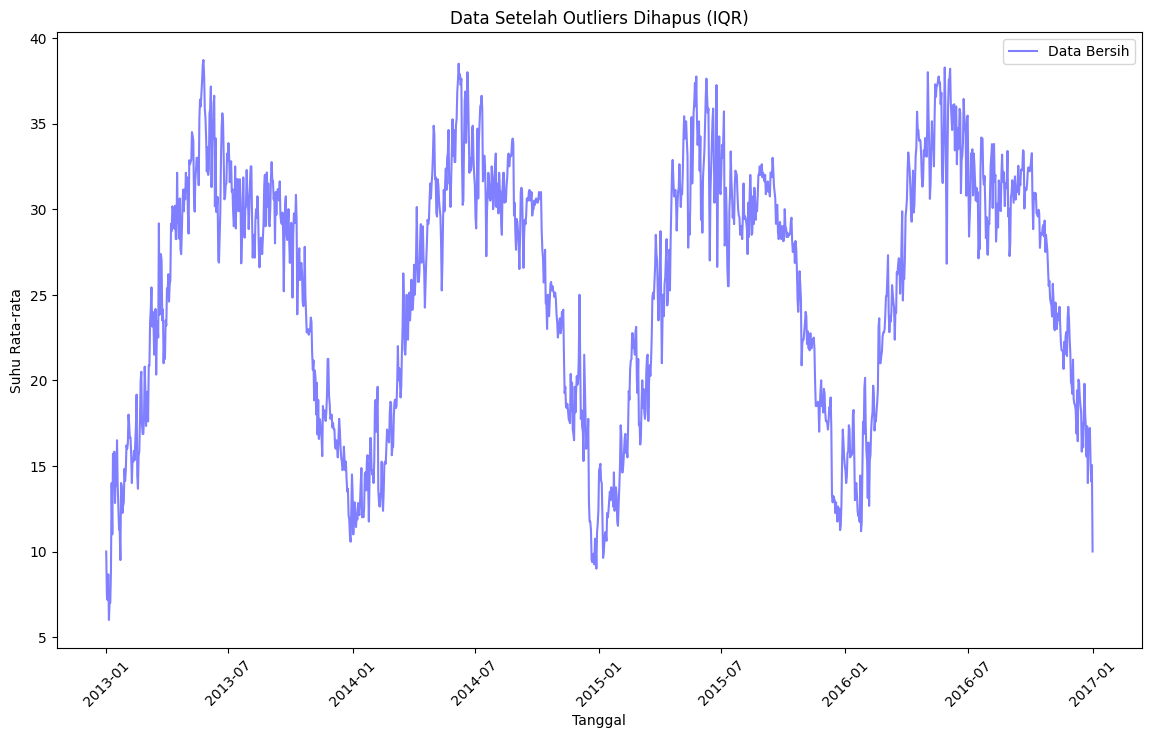

Outliers Setelah Dihapus (Should be None):
 Empty DataFrame
Columns: [meantemp, humidity, wind_speed, meanpressure]
Index: []


In [70]:
# --------------- Proses Penghapusan Outliers Menggunakan IQR ---------------

# Menghapus Outliers menggunakan IQR
df_clean = df[(df['meantemp'] >= lower_bound) & (df['meantemp'] <= upper_bound)]

# Identifikasi outliers setelah dihapus (seharusnya kosong jika tidak ada outlier yang tersisa)
outliers_after = df_clean[(df_clean['meantemp'] < lower_bound) | (df_clean['meantemp'] > upper_bound)]

# Plot Data Setelah Outliers dihapus
plt.figure(figsize=(14, 8))
plt.plot(df_clean.index, df_clean['meantemp'], label='Data Bersih', color='blue', alpha=0.5)
plt.title('Data Setelah Outliers Dihapus (IQR)')
plt.xlabel('Tanggal')
plt.ylabel('Suhu Rata-rata')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print outliers setelah dihapus (jika ada)
print("Outliers Setelah Dihapus (Should be None):\n", outliers_after)

In [71]:
# --------------- Resampling data (opsional, jika data memiliki tanggal yang hilang) ---------------
df_clean = df_clean.resample('D').mean()

# Mempersiapkan data suhu setelah preprocessing
temp_data = df_clean['meantemp']

# Menghapus outliers dari dataset
df_cleaned = df_clean

In [72]:
# -------------------- Data Smoothing --------------------

# 1. Moving Average Smoothing
window_size = 7  # 7-day moving average
moving_avg = temp_data.rolling(window=window_size).mean()

# 2. Exponential Smoothing with optimized alpha
# Grid search for alpha values
alphas = np.arange(0.1, 1.0, 0.1)
best_alpha = None
best_mse = float('inf')
best_fitted = None

for alpha in alphas:
    model = ExponentialSmoothing(temp_data, trend=None, seasonal=None).fit(smoothing_level=alpha)
    mse = ((temp_data - model.fittedvalues) ** 2).mean()  # Mean Squared Error
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_fitted = model.fittedvalues

print(f'Best Alpha: {best_alpha}, Best MSE: {best_mse}')

# 3. Gaussian Smoothing
sigma = 2  # Standard deviation for Gaussian kernel
gaussian_smoothing = gaussian_filter1d(temp_data, sigma=sigma)

Best Alpha: 0.8, Best MSE: 2.696629017966751


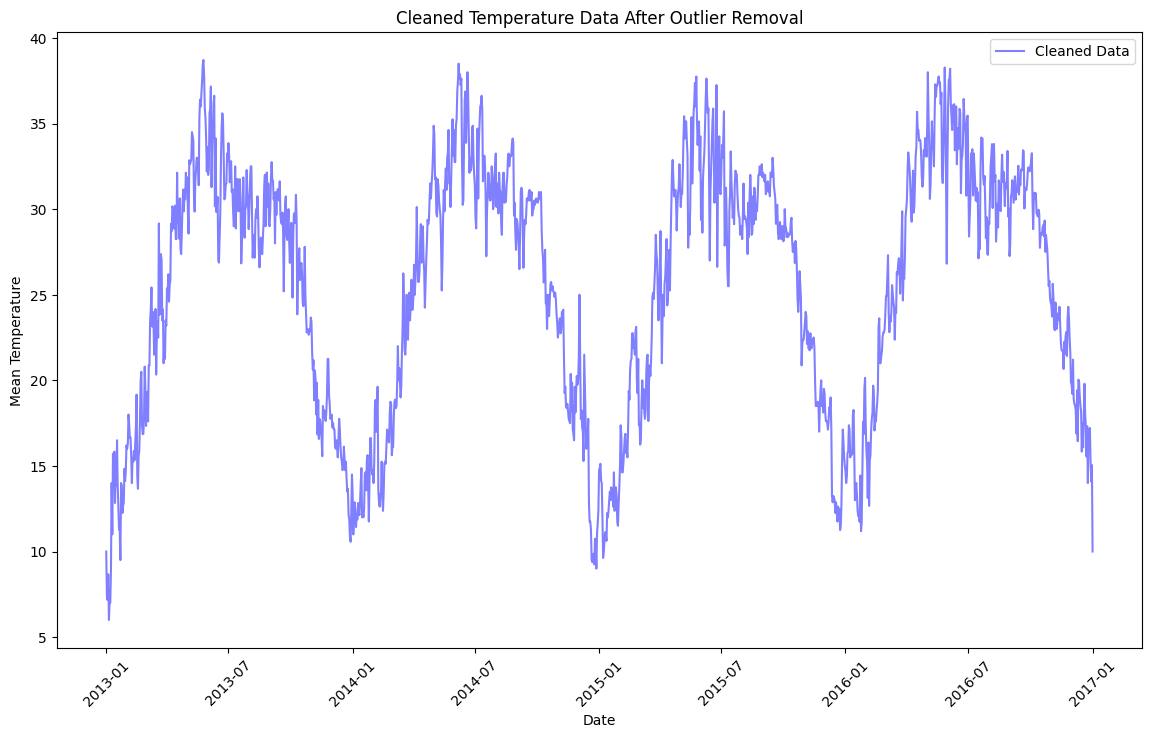

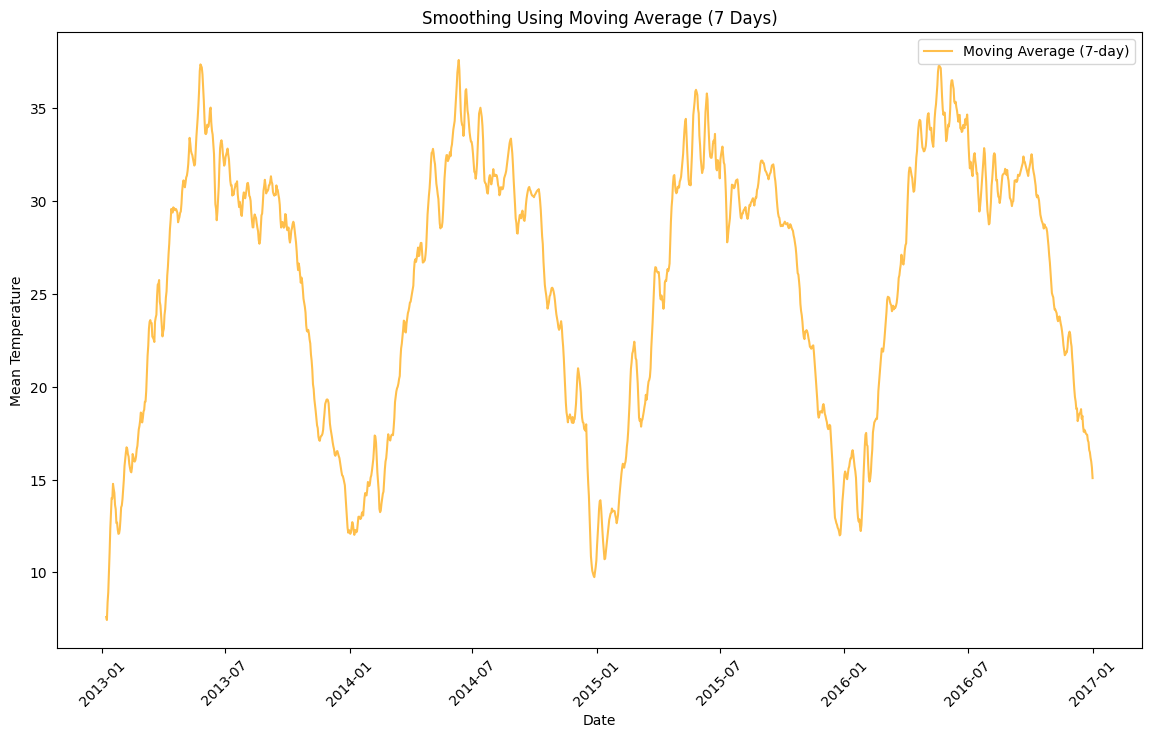

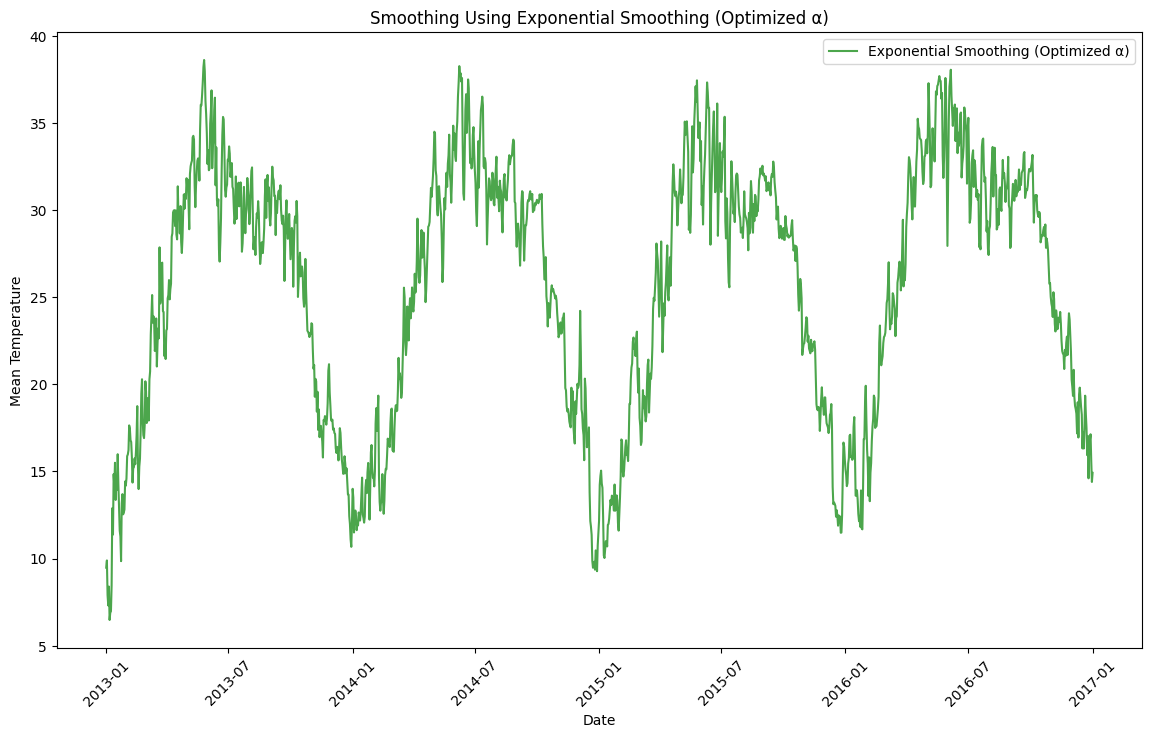

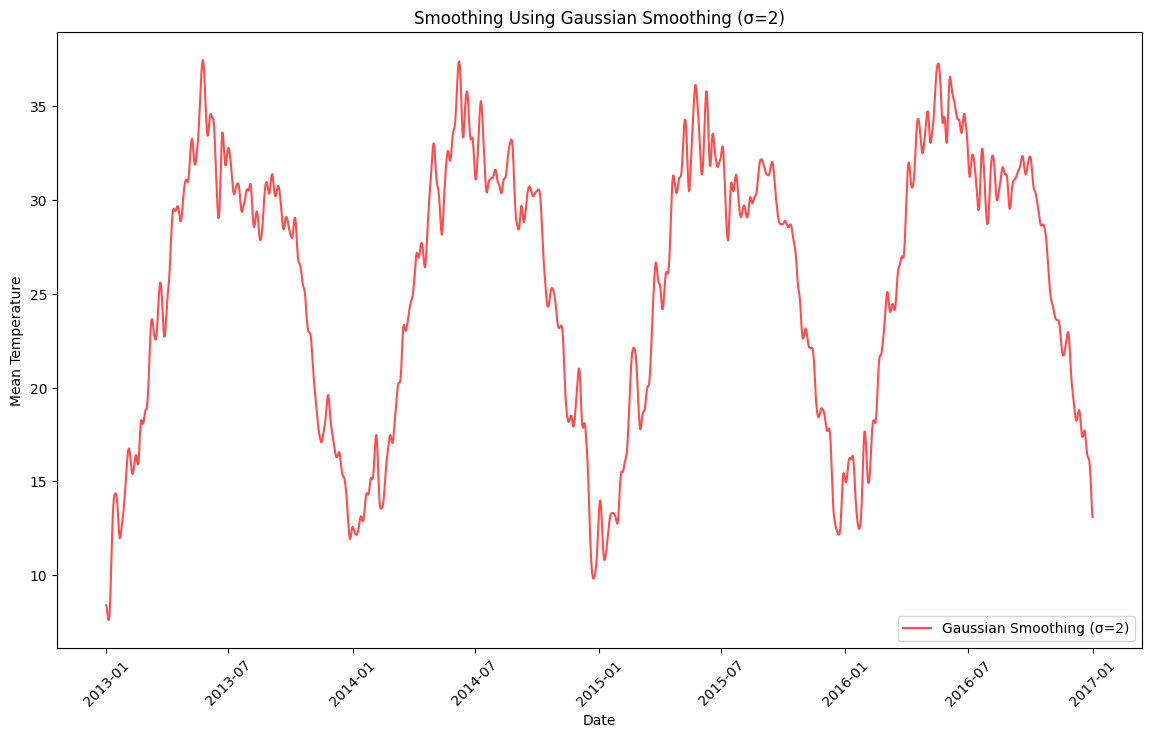

In [73]:
# -------------------- Plotting Results --------------------

# Plot Cleaned Data
plt.figure(figsize=(14, 8))
plt.plot(df_clean.index, temp_data, label='Cleaned Data', color='blue', alpha=0.5)
plt.title('Cleaned Temperature Data After Outlier Removal')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot Moving Average
plt.figure(figsize=(14, 8))
plt.plot(df_clean.index, moving_avg, label='Moving Average (7-day)', color='orange', alpha=0.7)
plt.title('Smoothing Using Moving Average (7 Days)')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot Exponential Smoothing
plt.figure(figsize=(14, 8))
plt.plot(df_cleaned.index, best_fitted, label='Exponential Smoothing (Optimized α)', color='green', alpha=0.7)
plt.title('Smoothing Using Exponential Smoothing (Optimized α)')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot Gaussian Smoothing
plt.figure(figsize=(14, 8))
plt.plot(df_clean.index, gaussian_smoothing, label='Gaussian Smoothing (σ=2)', color='red', alpha=0.7)
plt.title('Smoothing Using Gaussian Smoothing (σ=2)')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.show()

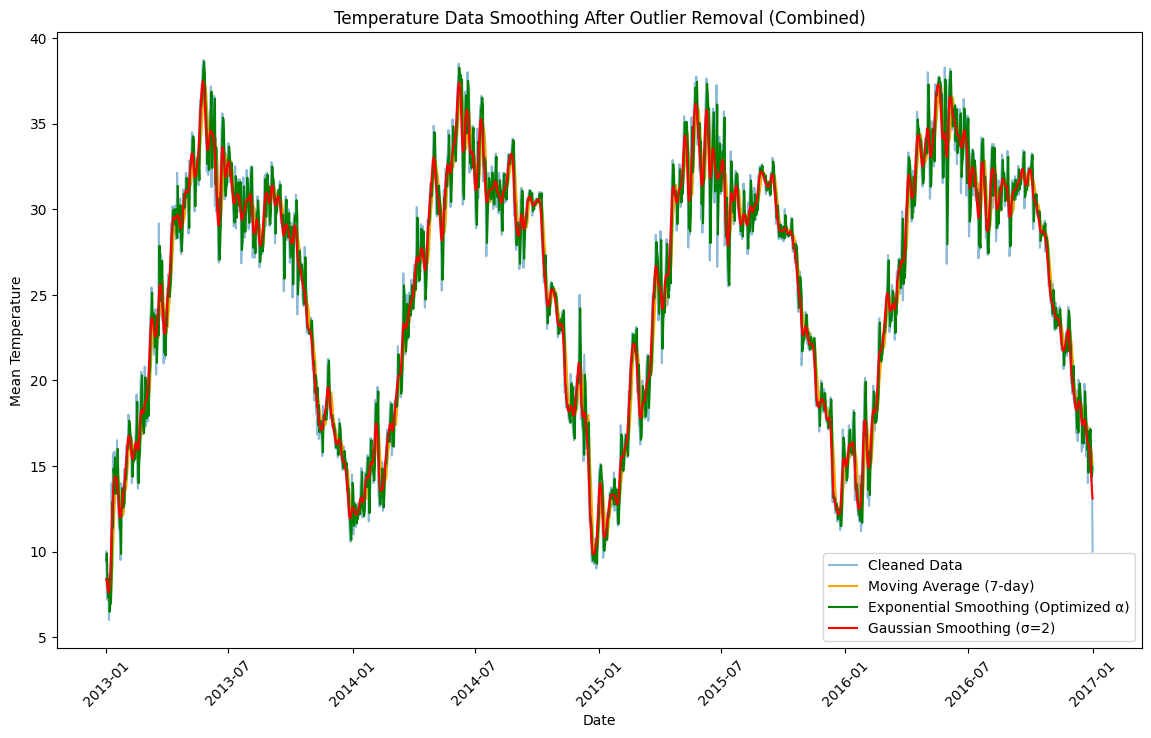

In [74]:
# Plot All Smoothing Methods Combined
plt.figure(figsize=(14, 8))

# Plot Cleaned Data
plt.plot(df_clean.index, temp_data, label='Cleaned Data', alpha=0.5)

# Plot Moving Average
plt.plot(df_clean.index, moving_avg, label='Moving Average (7-day)', color='orange')

# Plot Exponential Smoothing
plt.plot(df_cleaned.index, best_fitted, label='Exponential Smoothing (Optimized α)', color='green')

# Plot Gaussian Smoothing
plt.plot(df_clean.index, gaussian_smoothing, label='Gaussian Smoothing (σ=2)', color='red')

plt.title('Temperature Data Smoothing After Outlier Removal (Combined)')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.show()